In [2]:
import os

import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

%matplotlib inline

In [3]:
files = os.listdir('./results')
d0 = pd.read_csv('./results/' + files[0])

D = d0.loc[
    :, 
    ['subject', 'color', 'bp', 'wp', 'response', 'rt', 'splitg', 'n_pieces']
]

D = D.copy()

names = [f[14:-4] for f in files if f[:3]=='app']

for f in files:
    if f[:3]=='app':
        _d = pd.read_csv('./results/' + f)
        D.loc[:, f[14:-4]] = _d.cnn_nll.values
    
D.head()

,subject,color,bp,wp,response,rt,splitg,n_pieces,naive_1,naive_128,...,naive_8,smart_1,smart_128,smart_16,smart_2,smart_256,smart_32,smart_4,smart_64,smart_8
0,0,0,000000000000000000000000000000000000,000000000000000000000000000000000000,11,7223,5,0,3.516745,4.128196,...,3.884012,3.546878,4.156188,4.037173,3.698342,4.186132,4.094836,4.019267,4.143282,3.887828
1,1,1,000000000000000000000000000000000000,000000000001000000000000000000000000,24,5141,5,1,3.588722,4.244206,...,4.161124,3.568749,4.443789,4.488919,3.894595,4.552783,4.360919,4.377874,4.266925,4.397906
2,0,0,000000000001000000000000000000000000,000000000000000000000000100000000000,21,3154,5,2,2.761279,2.656283,...,2.714588,2.712107,2.702742,2.805940,2.631602,2.804832,2.510506,2.553612,2.656333,2.450614
3,1,1,000000000000000000000000100000000000,000000000001000000000100000000000000,31,5715,4,3,2.744632,0.757582,...,2.663838,2.962218,0.889912,1.549567,2.885014,0.762685,1.037952,2.643039,0.903978,2.191686
4,0,0,000000000001000000000100000000000000,000000000000000000000000100000010000,14,6837,3,4,2.631289,3.979000,...,3.255823,2.811628,4.013144,3.200343,2.605702,4.114066,3.300314,3.008024,3.583677,3.317387


In [5]:
L = pd.read_csv('./results/loglik_by_board_default.txt', names=['n_pieces', 'default'])
D.loc[:, 'default'] = L.default.values

In [6]:
levels = 2**np.arange(9)
types = ['smart', 'naive']
m_smart, m_naive, l_smart, l_naive, u_smart, u_naive = [np.zeros(9) for _ in range(6)]

for name in names:
    n = np.log2(int(name[6:]))
    if name[:5]=='naive':
        m, l, u = m_naive, l_naive, u_naive
    else:
        m, l, u = m_smart, l_smart, u_smart
    
    mstats, _, _ = sts.bayes_mvs(D.loc[:, name].values)
    m[n] = mstats[0]
    l[n] = mstats[1][0]
    u[n] = mstats[1][1]
    
mstats_default, _, _ = sts.bayes_mvs(D.loc[:, 'default'].values)
m_default, l_default, u_default = mstats_default[0], mstats_default[1][0], mstats_default[1][1]

/Users/gianni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gianni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gianni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Is 32 filters significantly better than 16?
 Ttest_indResult(statistic=2.824811767905997, pvalue=0.0047393843761417325)
Is 64 better than 32?
 Ttest_indResult(statistic=0.2794634170172306, pvalue=0.77989448143014772)
Just to check, is smart 32 better than naive 32?
 Ttest_indResult(statistic=-4.8114314251573074, pvalue=1.5185083975927674e-06)
It is official: best CNN is 32 filter with rule knowledge


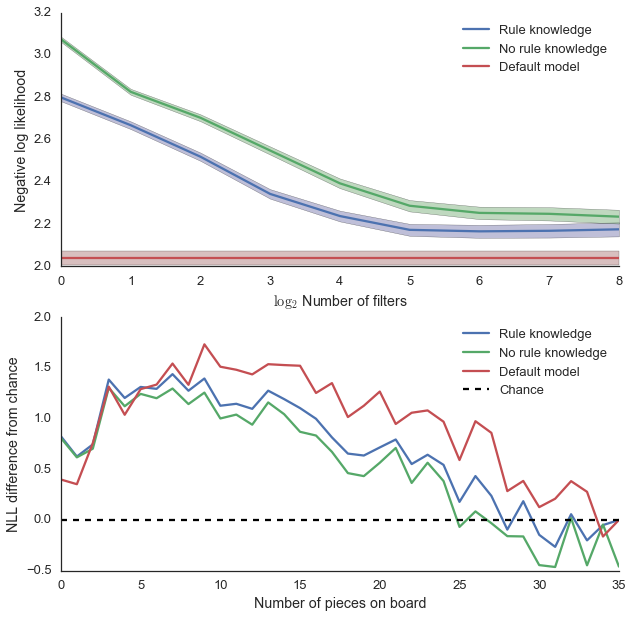

In [7]:
print(
    'Is 32 filters significantly better than 16?\n', 
    sts.ttest_ind(D.smart_16.values, D.smart_32.values)
)

print(
    'Is 64 better than 32?\n',
    sts.ttest_ind(D.smart_32.values, D.smart_64.values)
)

print(
    'Just to check, is smart 32 better than naive 32?\n',
    sts.ttest_ind(D.smart_32.values, D.naive_32.values)
)

print(
    'It is official: best CNN is 32 filter with rule knowledge'
)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), squeeze=False)

trends = axes[0, 0]
per_piece = axes[1, 0]

trends.plot(np.arange(9), m_smart, label='Rule knowledge')
trends.fill_between(np.arange(9), l_smart, u_smart, zorder=0, alpha=.5, facecolor=(.5, .5, .7))

trends.plot(np.arange(9), m_naive, label='No rule knowledge')
trends.fill_between(np.arange(9), l_naive, u_naive, zorder=1, alpha=.5, facecolor=(.5, .7, .5))

trends.plot([0, 8], [m_default, m_default], label='Default model')
trends.fill_between(
    [0, 8], [l_default,]*2, [u_default,]*2, 
    alpha=.5, facecolor=(.7, .5, .5)
)

plt.setp(trends, xlabel=r'$\log_2{}$ Number of filters', ylabel='Negative log likelihood')

trends.legend()

_D = D.pivot_table(
    index='n_pieces', 
    values=['smart_32', 'naive_32', 'default'], 
    aggfunc=np.mean
)

_D.loc[:, :] = -_D.values - np.log(1/np.arange(1, 37)[::-1])[:, np.newaxis]

per_piece.plot(_D.smart_32, label='Rule knowledge')
per_piece.plot(_D.naive_32, label='No rule knowledge')
per_piece.plot(_D.default, label='Default model')
per_piece.plot([0, 35], [0, 0], linestyle='--', label='Chance', color='black')
per_piece.legend()

plt.setp(
    per_piece, 
    xlabel='Number of pieces on board', 
    ylabel='NLL difference from chance'
)

sns.despine()
fig.savefig('./results/trends.png')

In [8]:
names

['naive_1',
 'naive_128',
 'naive_16',
 'naive_2',
 'naive_256',
 'naive_32',
 'naive_4',
 'naive_64',
 'naive_8',
 'smart_1',
 'smart_128',
 'smart_16',
 'smart_2',
 'smart_256',
 'smart_32',
 'smart_4',
 'smart_64',
 'smart_8']

In [10]:
B = pd.read_csv('./results/appended_data_smart_32.csv')
B.columns

Index(['subject', 'color', 'bp', 'wp', 'response', 'rt', 'splitg', 'cnn_nll',
       'n_pieces', 'cnn_0', 'cnn_1', 'cnn_2', 'cnn_3', 'cnn_4', 'cnn_5',
       'cnn_6', 'cnn_7', 'cnn_8', 'cnn_9', 'cnn_10', 'cnn_11', 'cnn_12',
       'cnn_13', 'cnn_14', 'cnn_15', 'cnn_16', 'cnn_17', 'cnn_18', 'cnn_19',
       'cnn_20', 'cnn_21', 'cnn_22', 'cnn_23', 'cnn_24', 'cnn_25', 'cnn_26',
       'cnn_27', 'cnn_28', 'cnn_29', 'cnn_30', 'cnn_31', 'cnn_32', 'cnn_33',
       'cnn_34', 'cnn_35', 'prediction'],
      dtype='object')

In [73]:
reconstitute = lambda x: np.array(list(map(int, x))).reshape(4,9)

def show_output(pos, ax, df, show_zet=False):
    positions = ['cnn_' + str(i) for i in range(36)]
    d = df.loc[pos, positions].values.reshape([4,9]).astype(float)

    sns.heatmap(
        d, ax=ax, 
        square=True, vmin=0, vmax=.25, cbar=False, linewidth=.5, linecolor='black',
        cmap=sns.palettes.blend_palette(['#999999', '#66FF66'], as_cmap=True),
        xticklabels=False, yticklabels=False, annot=True, fmt='.2f'
    )

    if df.loc[pos, 'color'] == 0:
        own_color, opp_color = 'black', 'white'
    else:
        own_color, opp_color = 'white', 'black'

    p = np.where(reconstitute(df.loc[pos, 'bp'])==1)
    plt.scatter( .5 + p[1], 3.5 - p[0], c=own_color, s=10000)
    
    p = np.where(reconstitute(df.loc[pos, 'wp'])==1)
    plt.scatter( .5 + p[1], 3.5 - p[0], c=opp_color, s=10000)
    
    if show_zet:
        r = B.loc[pos, 'response']
        p = (r % 9, r // 9)
        plt.plot(
            p[0] + .5, 3.5 - p[1], 
            linestyle='None', 
            marker='o', markersize=100, markerfacecolor='None', 
            markeredgecolor='black', markeredgewidth=5
        );
        

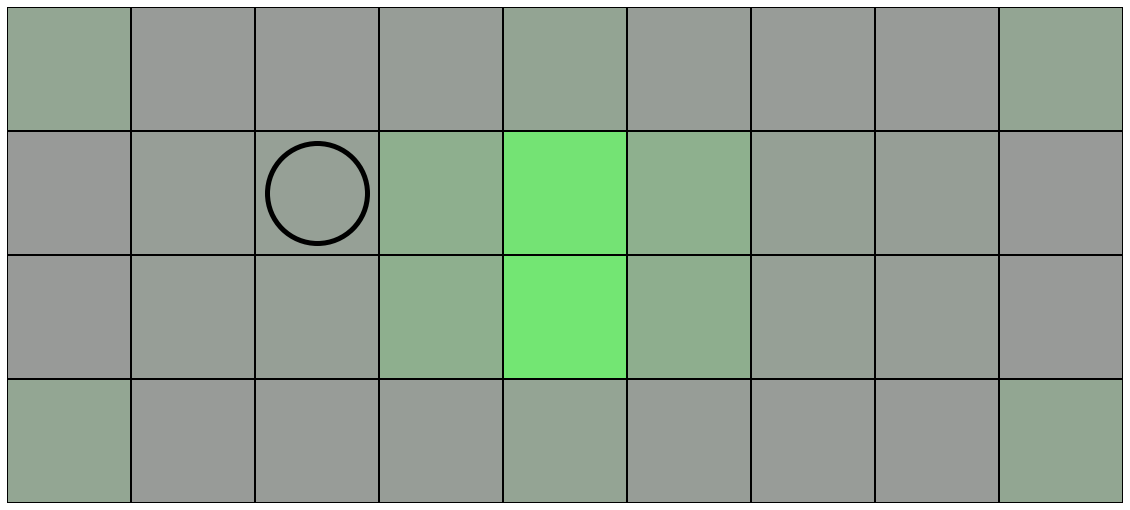

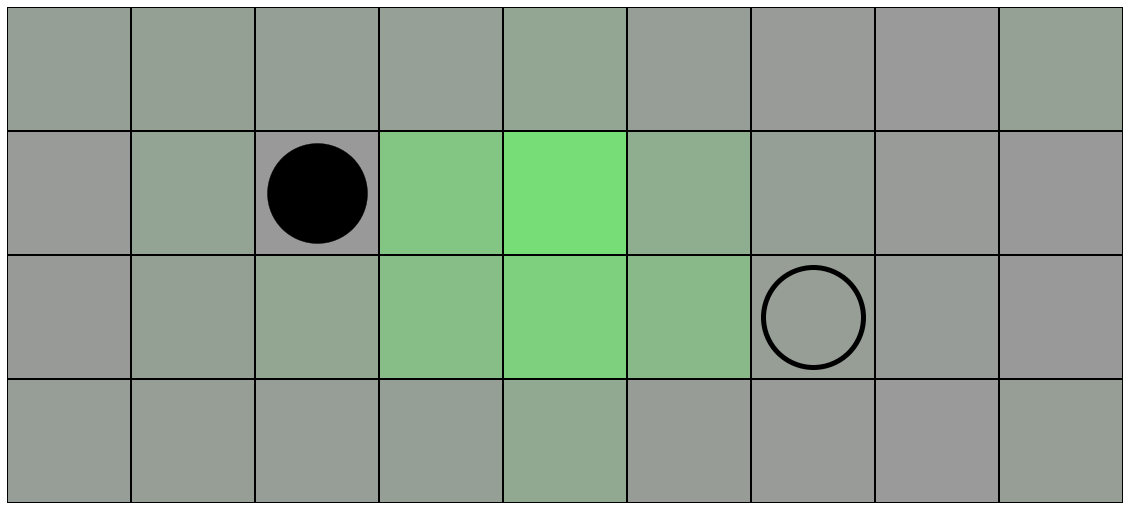

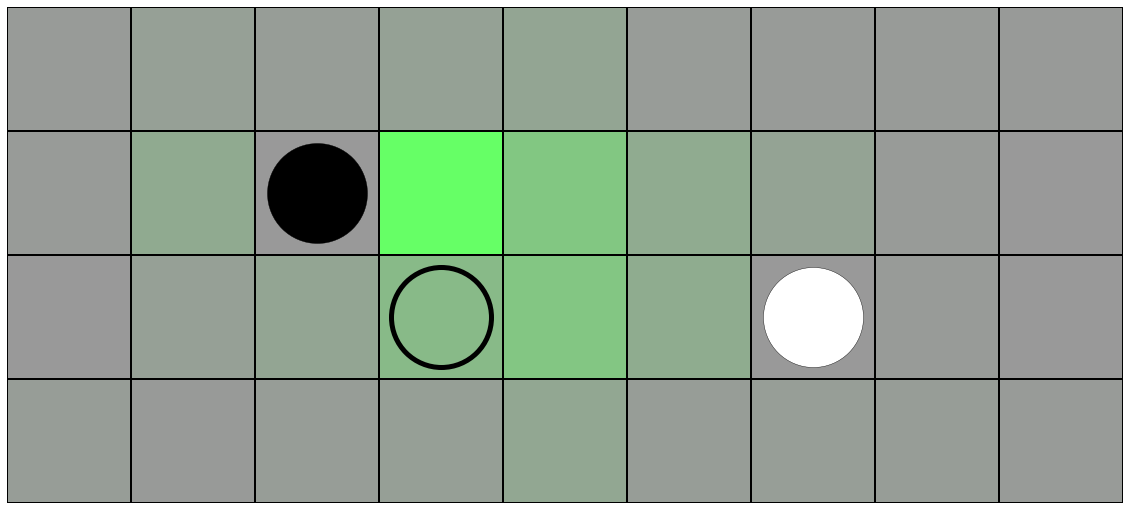

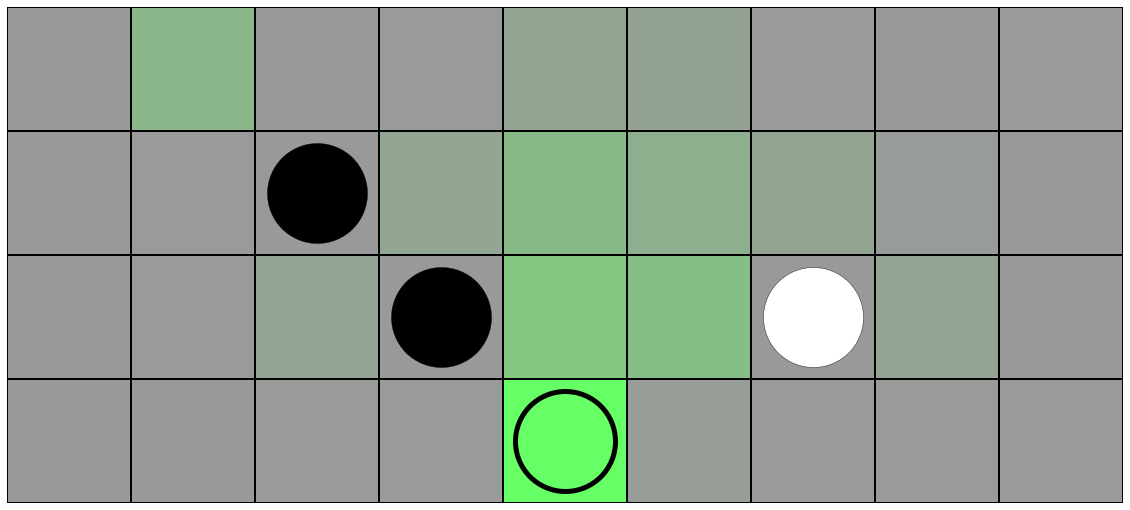

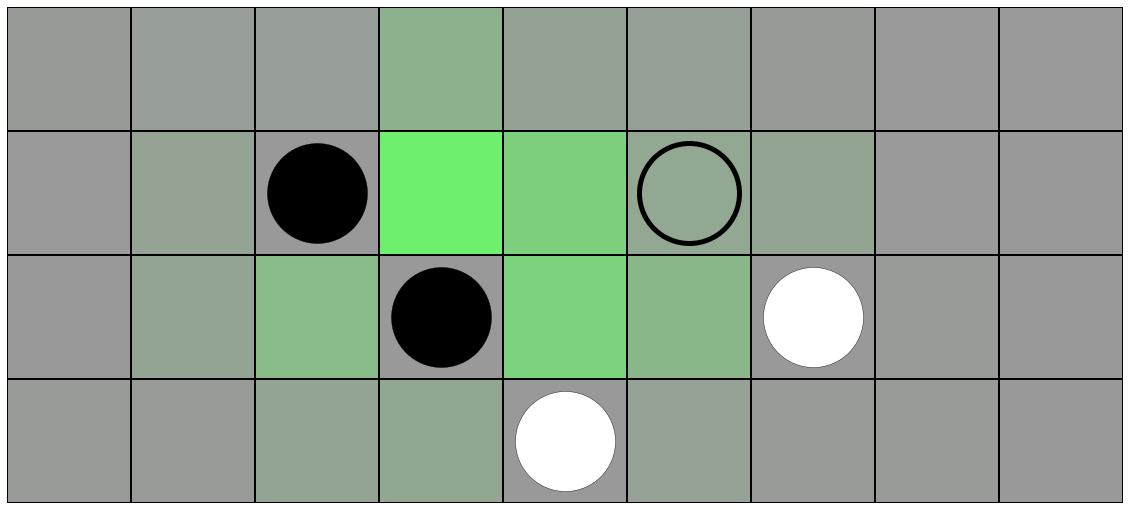

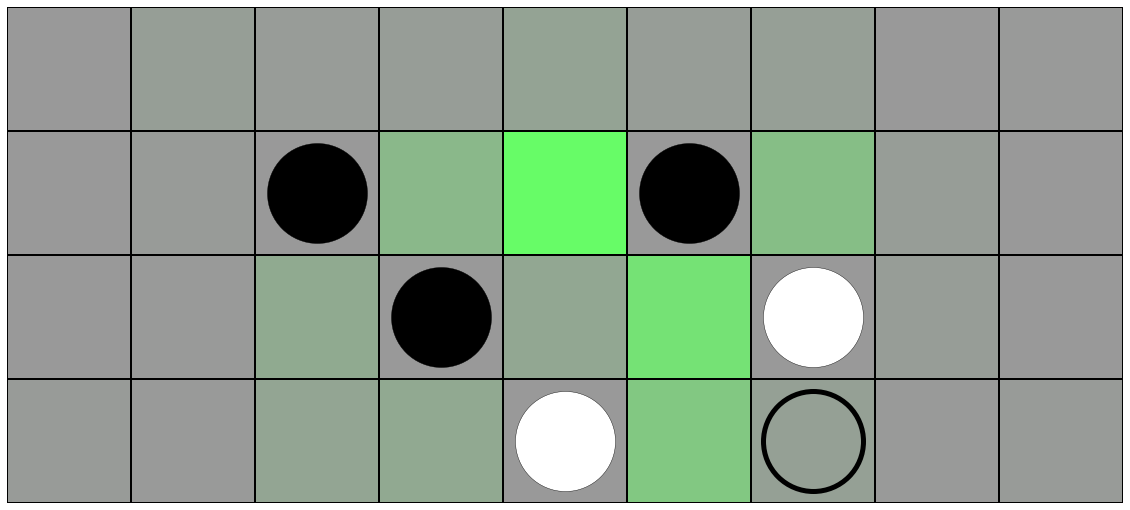

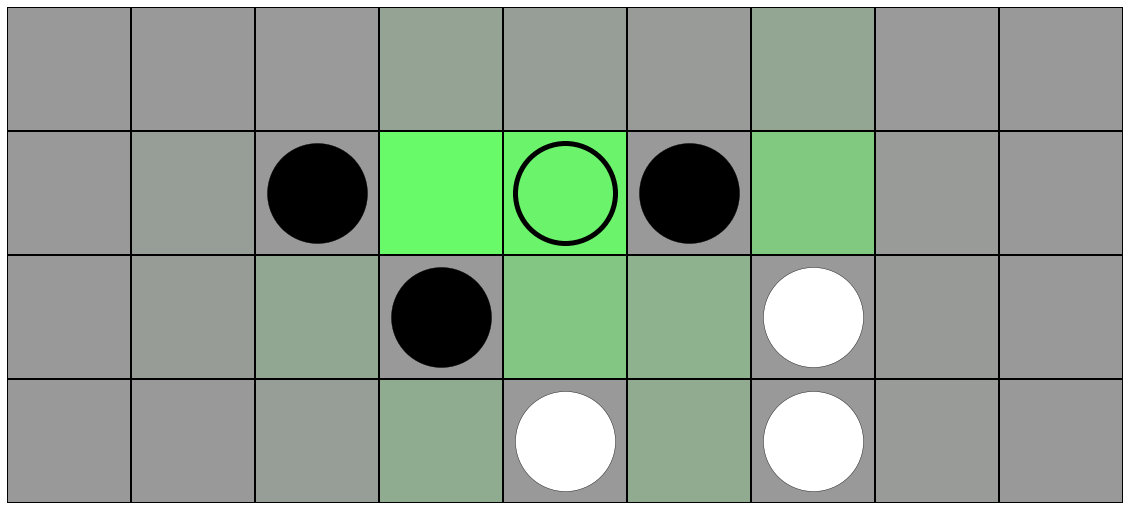

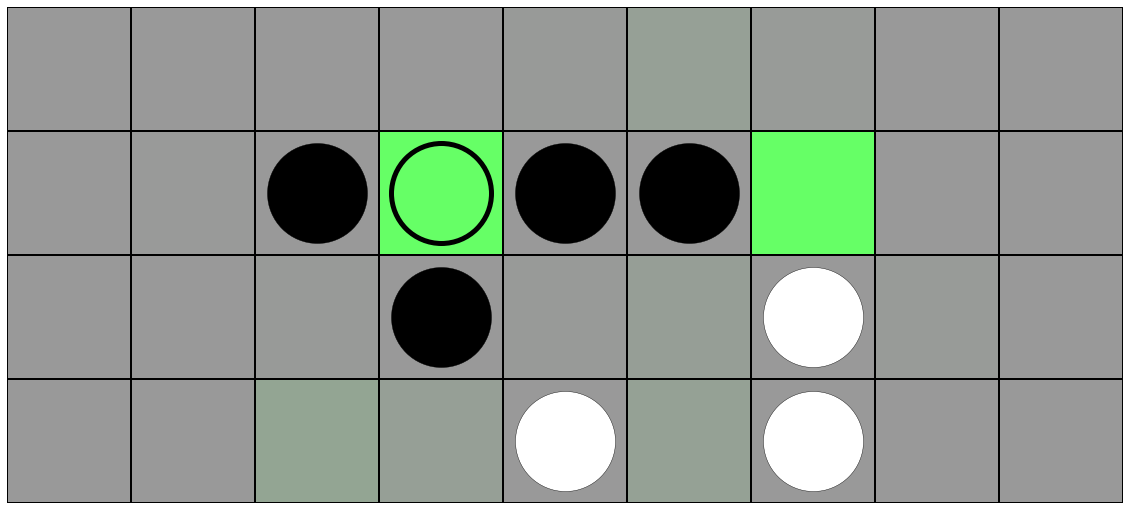

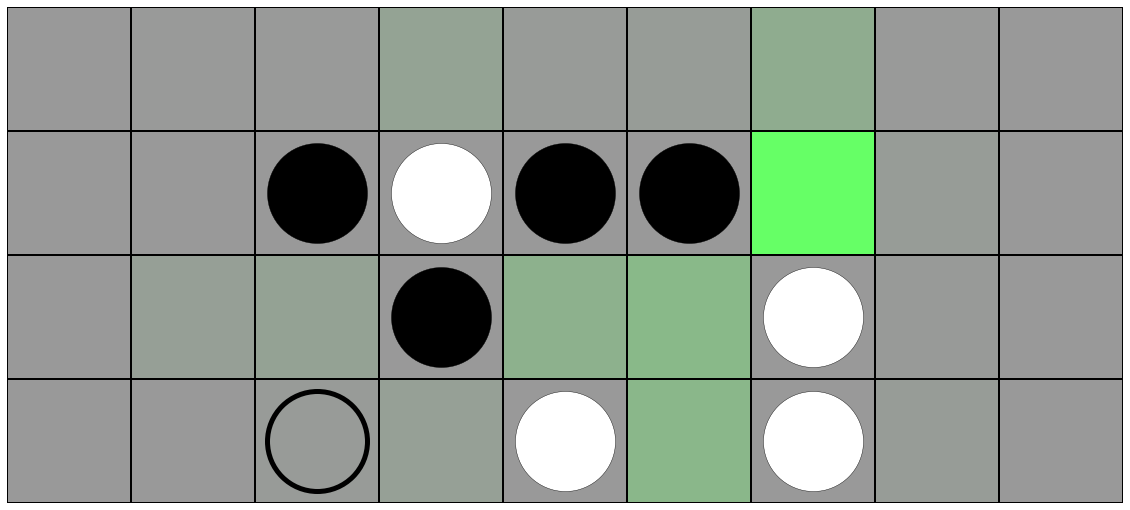

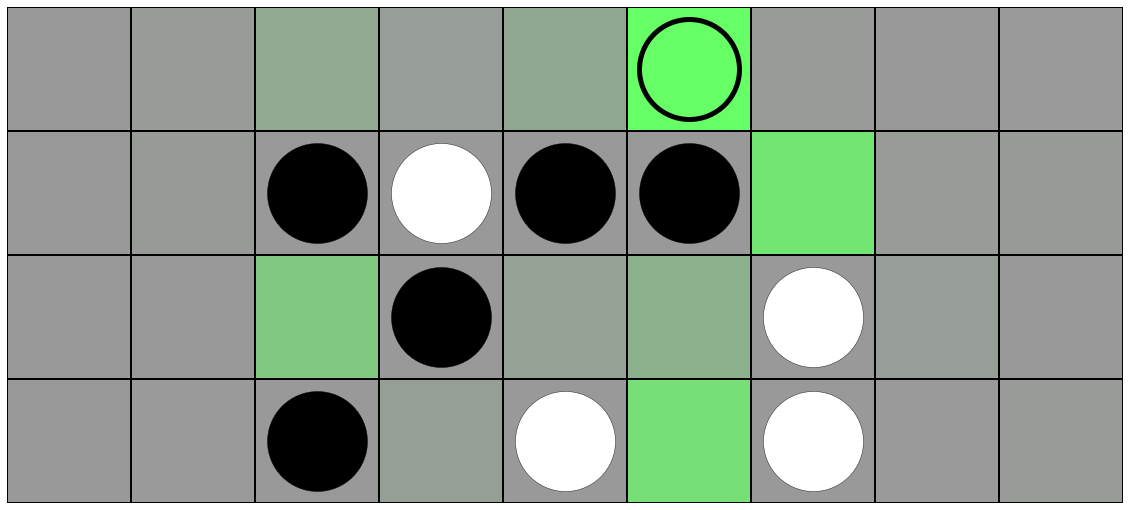

In [79]:
for i in range(10):
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))

    show_output(pos=i, ax=axes, df=B, show_zet=True)

    fig.savefig('example' + str(i) + '.png', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))